In [57]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est[:3, :3],
        T_est[:3, 3],
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta[:3, :3],
        T_sta[:3, 3],
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    ax.set_zlim(0, 0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-0.3, 0, 0.3])
    ax.set_yticks([-0.3, 0, 0.3])
    ax.set_zticks([0, 0.15, 0.3])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

def construct_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T


## Mainshell
$$ T_\text{ee}^\text{base} = T_\text{part}^\text{base} T_\text{ee}^\text{part} $$

The goal is to find $T_\text{ee}^\text{part}$ for each stable pose.

This is top facing.


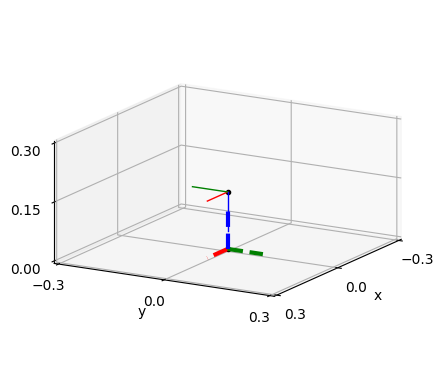

This is bottom facing.


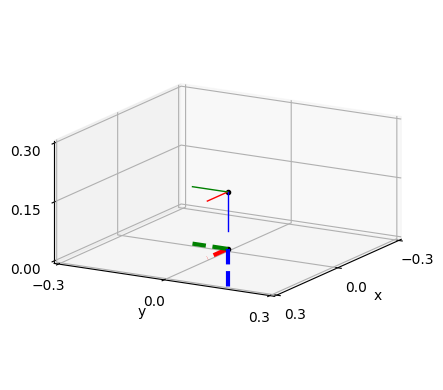

In [58]:
def grasping_mapping_mainshell(T_part_in_base):
    [alpha, beta, gamma] = Rotation.from_matrix(T_part_in_base[:3, :3]).as_euler('xyz', degrees=True)
    T_ee_in_part = np.eye(4)
    if alpha==0.:
        print("This is top facing.")
        # rotate 180 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([180, 0, 0])).as_matrix()
        T_ee_in_part[:3,:3] = R_ee_in_part
        # shift 0.145m along z axis
        T_ee_in_part[2,3] = 0.145
    elif alpha==180.:
        print("This is bottom facing.")
        # remain the same orientaion
        R_ee_in_part = np.eye(3)
        T_ee_in_part[:3,:3] = R_ee_in_part
        # shift 0.145m along z axis, but in negtive direction
        T_ee_in_part[2,3] = -0.145
    return T_ee_in_part

T_part_in_base_topfacing = construct_T(Rotation.from_euler('xyz', np.radians([0, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_topfacing = grasping_mapping_mainshell(T_part_in_base_topfacing)
T_ee_in_base_topfacing = T_part_in_base_topfacing @ T_ee_in_part_topfacing
draw_results(T_part_in_base_topfacing, T_ee_in_base_topfacing, s=0.1)

T_part_in_base_bottomfacing = construct_T(Rotation.from_euler('xyz', np.radians([180, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_bottomfacing = grasping_mapping_mainshell(T_part_in_base_bottomfacing)
T_ee_in_base_bottomfacing = T_part_in_base_bottomfacing @ T_ee_in_part_bottomfacing
draw_results(T_part_in_base_bottomfacing, T_ee_in_base_bottomfacing, s=0.1)

# The solid line is for T_ee_in_base
# The dashed line is for T_part_in_base

## Topshell

This is top facing.


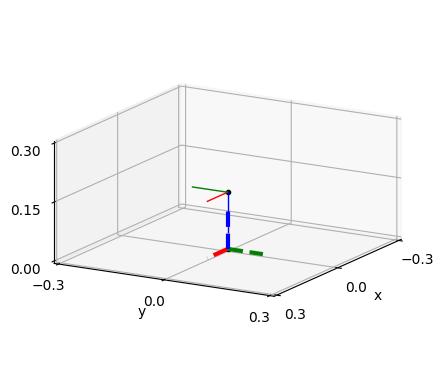

This is bottom facing.


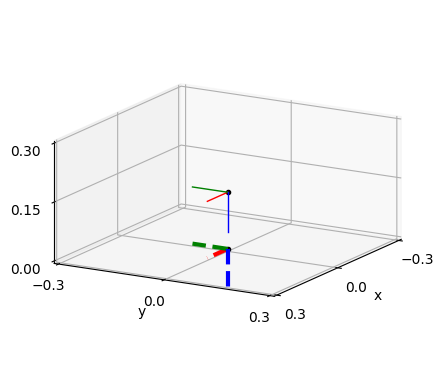

This has tilted angle.


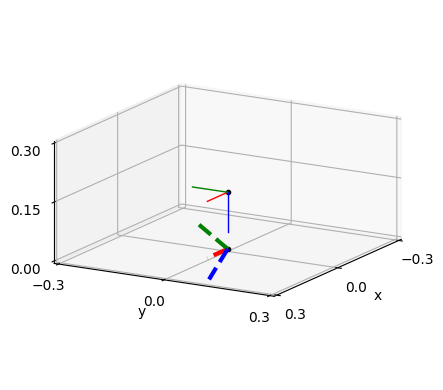

In [59]:
def grasping_mapping_topshell(T_part_in_base):
    [alpha, beta, gamma] = Rotation.from_matrix(T_part_in_base[:3, :3]).as_euler('xyz', degrees=True)
    T_ee_in_part = np.eye(4)
    if alpha==0.:
        print("This is top facing.")
        # rotate 180 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([180, 0, 0])).as_matrix()
        T_ee_in_part[:3,:3] = R_ee_in_part
        # shift 0.145m along z axis
        T_ee_in_part[2,3] = 0.1443
    elif alpha==180.:
        print("This is bottom facing.")
        # remain the same orientaion
        R_ee_in_part = np.eye(3)
        T_ee_in_part[:3,:3] = R_ee_in_part
        # shift 0.145m along z axis, but in negtive direction
        T_ee_in_part[2,3] = -0.1443
    elif alpha==148.:
        print("This has tilted angle.")
        # rotate 32 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([32, 0, 0])).as_matrix()
        R_part_in_ee = np.linalg.inv(R_ee_in_part)
        t_part_in_ee = np.array([0, 0, 0.1443])
        T_part_in_ee = construct_T(R_part_in_ee, t_part_in_ee)
        T_ee_in_part = np.linalg.inv(T_part_in_ee)

    return T_ee_in_part

T_part_in_base_topfacing = construct_T(Rotation.from_euler('xyz', np.radians([0, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_topfacing = grasping_mapping_topshell(T_part_in_base_topfacing)
T_ee_in_base_topfacing = T_part_in_base_topfacing @ T_ee_in_part_topfacing
draw_results(T_part_in_base_topfacing, T_ee_in_base_topfacing, s=0.1)

T_part_in_base_bottomfacing = construct_T(Rotation.from_euler('xyz', np.radians([180, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_bottomfacing = grasping_mapping_topshell(T_part_in_base_bottomfacing)
T_ee_in_base_bottomfacing = T_part_in_base_bottomfacing @ T_ee_in_part_bottomfacing
draw_results(T_part_in_base_bottomfacing, T_ee_in_base_bottomfacing, s=0.1)

T_part_in_base_tilted = construct_T(Rotation.from_euler('xyz', np.radians([148, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_tilted = grasping_mapping_topshell(T_part_in_base_tilted)
T_ee_in_base_tilted = T_part_in_base_tilted @ T_ee_in_part_tilted
draw_results(T_part_in_base_tilted, T_ee_in_base_tilted, s=0.1)

# The solid line is for T_ee_in_base
# The dashed line is for T_part_in_base

## Insert Mold

This is top facing.


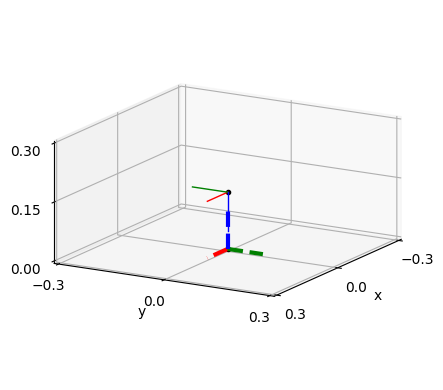

This topfacing has tilted angle 12 degrees.


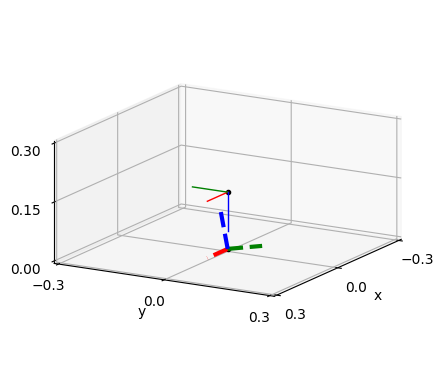

This bottomfacing has tilted angle 156 degrees.


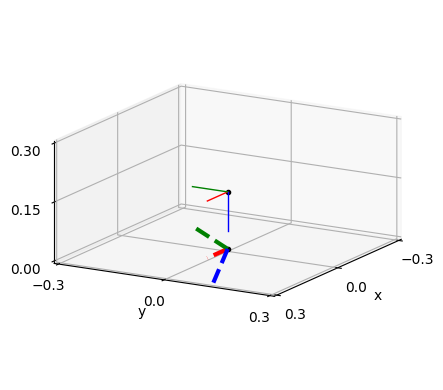

This bottomfacing has tilted angle -146 degrees.


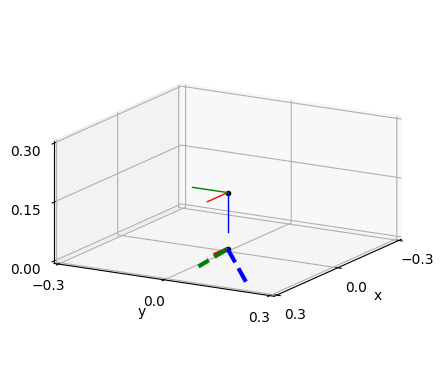

In [60]:
def grasping_mapping_insertmold(T_part_in_base):
    [alpha, beta, gamma] = Rotation.from_matrix(T_part_in_base[:3, :3]).as_euler('xyz', degrees=True)
    T_ee_in_part = np.eye(4)
    if alpha==0.:
        print("This is top facing.")
        # rotate 180 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([180, 0, 0])).as_matrix()
        T_ee_in_part[:3,:3] = R_ee_in_part
        # shift 0.145m along z axis
        T_ee_in_part[2,3] = 0.1444
    elif alpha==12.:
        print("This topfacing has tilted angle 12 degrees.")
        # rotate 168 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([168, 0, 0])).as_matrix()
        R_part_in_ee = np.linalg.inv(R_ee_in_part)
        t_part_in_ee = np.array([0, 0, 0.1445])
        T_part_in_ee = construct_T(R_part_in_ee, t_part_in_ee)
        T_ee_in_part = np.linalg.inv(T_part_in_ee)
    elif alpha==156.:
        print("This bottomfacing has tilted angle 156 degrees.")
        # rotate 24 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([24, 0, 0])).as_matrix()
        R_part_in_ee = np.linalg.inv(R_ee_in_part)
        t_part_in_ee = np.array([0, 0, 0.1452])
        T_part_in_ee = construct_T(R_part_in_ee, t_part_in_ee)
        T_ee_in_part = np.linalg.inv(T_part_in_ee)
    elif alpha==-146.:
        print("This bottomfacing has tilted angle -146 degrees.")
        # rotate -34 degrees around x axis
        R_ee_in_part = Rotation.from_euler('xyz', np.radians([-34, 0, 0])).as_matrix()
        R_part_in_ee = np.linalg.inv(R_ee_in_part)
        t_part_in_ee = np.array([0, 0, 0.1434])
        T_part_in_ee = construct_T(R_part_in_ee, t_part_in_ee)
        T_ee_in_part = np.linalg.inv(T_part_in_ee)

    return T_ee_in_part

T_part_in_base_topfacing = construct_T(Rotation.from_euler('xyz', np.radians([0, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_topfacing = grasping_mapping_insertmold(T_part_in_base_topfacing)
T_ee_in_base_topfacing = T_part_in_base_topfacing @ T_ee_in_part_topfacing
draw_results(T_part_in_base_topfacing, T_ee_in_base_topfacing, s=0.1)

T_part_in_base_top_tilted_12 = construct_T(Rotation.from_euler('xyz', np.radians([12, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_top_tilted_12 = grasping_mapping_insertmold(T_part_in_base_top_tilted_12)
T_ee_in_base_top_tilted_12 = T_part_in_base_top_tilted_12 @ T_ee_in_part_top_tilted_12
draw_results(T_part_in_base_top_tilted_12, T_ee_in_base_top_tilted_12, s=0.1)

T_part_in_base_bottom_tilted_156 = construct_T(Rotation.from_euler('xyz', np.radians([156, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_bottom_tilted_156 = grasping_mapping_insertmold(T_part_in_base_bottom_tilted_156)
T_ee_in_base_bottom_tilted_156 = T_part_in_base_bottom_tilted_156 @ T_ee_in_part_bottom_tilted_156
draw_results(T_part_in_base_bottom_tilted_156, T_ee_in_base_bottom_tilted_156, s=0.1)

T_part_in_base_bottom_tilted_n146 = construct_T(Rotation.from_euler('xyz', np.radians([-146, 0, 0])).as_matrix(), np.array([0, 0, 0]))
T_ee_in_part_bottom_tilted_n146 = grasping_mapping_insertmold(T_part_in_base_bottom_tilted_n146)
T_ee_in_base_bottom_tilted_n146 = T_part_in_base_bottom_tilted_n146 @ T_ee_in_part_bottom_tilted_n146
draw_results(T_part_in_base_bottom_tilted_n146, T_ee_in_base_bottom_tilted_n146, s=0.1)

# The solid line is for T_ee_in_base
# The dashed line is for T_part_in_base